# Perturbing cell type composition


In [1]:
import importlib
import logging

import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
from upath import UPath

In [2]:
import plotly.io as pio

pio.renderers["png"].scale = 5

In [3]:
pio.renderers.default = "png"

In [4]:
helpers.logging.configure_logging()
logging.getLogger("helpers").setLevel("DEBUG")
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test")

2023-01-27 14:48:40,770 6789/MainThread __main__ DEBUG
test


In [5]:
path_root = UPath("gs://liulab/differential_composition") / "20230120_04h22m54s"
# 20221208_14h18m38s last week
# 20221215_05h09m48s like last week but with more 0 perturbation experiments
# 20221215_05h06m59s recreation of last week, showed a significantly different perturbation=0
# 20221215_04h42m35s with N = 1000
# 20221215_06h29m44s a few experiments per perturbation
# 20230120_04h22m54s better fraction perturbation and sampling

## check fractions

In [6]:
df_fractions = dd.read_parquet(path_root / "**" / "fractions.parquet").compute()
df_fractions[["group_id", "sample_id"]] = (
    df_fractions.index.get_level_values("sample_id").str.split("/", expand=True).tolist()
)
process_row = lambda row: row["malignant_means"].split(",")[0 if row["group_id"] == "low" else 1]
df_fractions["malignant_mean_value"] = df_fractions.apply(process_row, axis=1)
df_fractions = df_fractions.set_index(["malignant_means", "group_id", "malignant_mean_value", "sample_id", "run_id"])

### dist plot of fractions per experiment

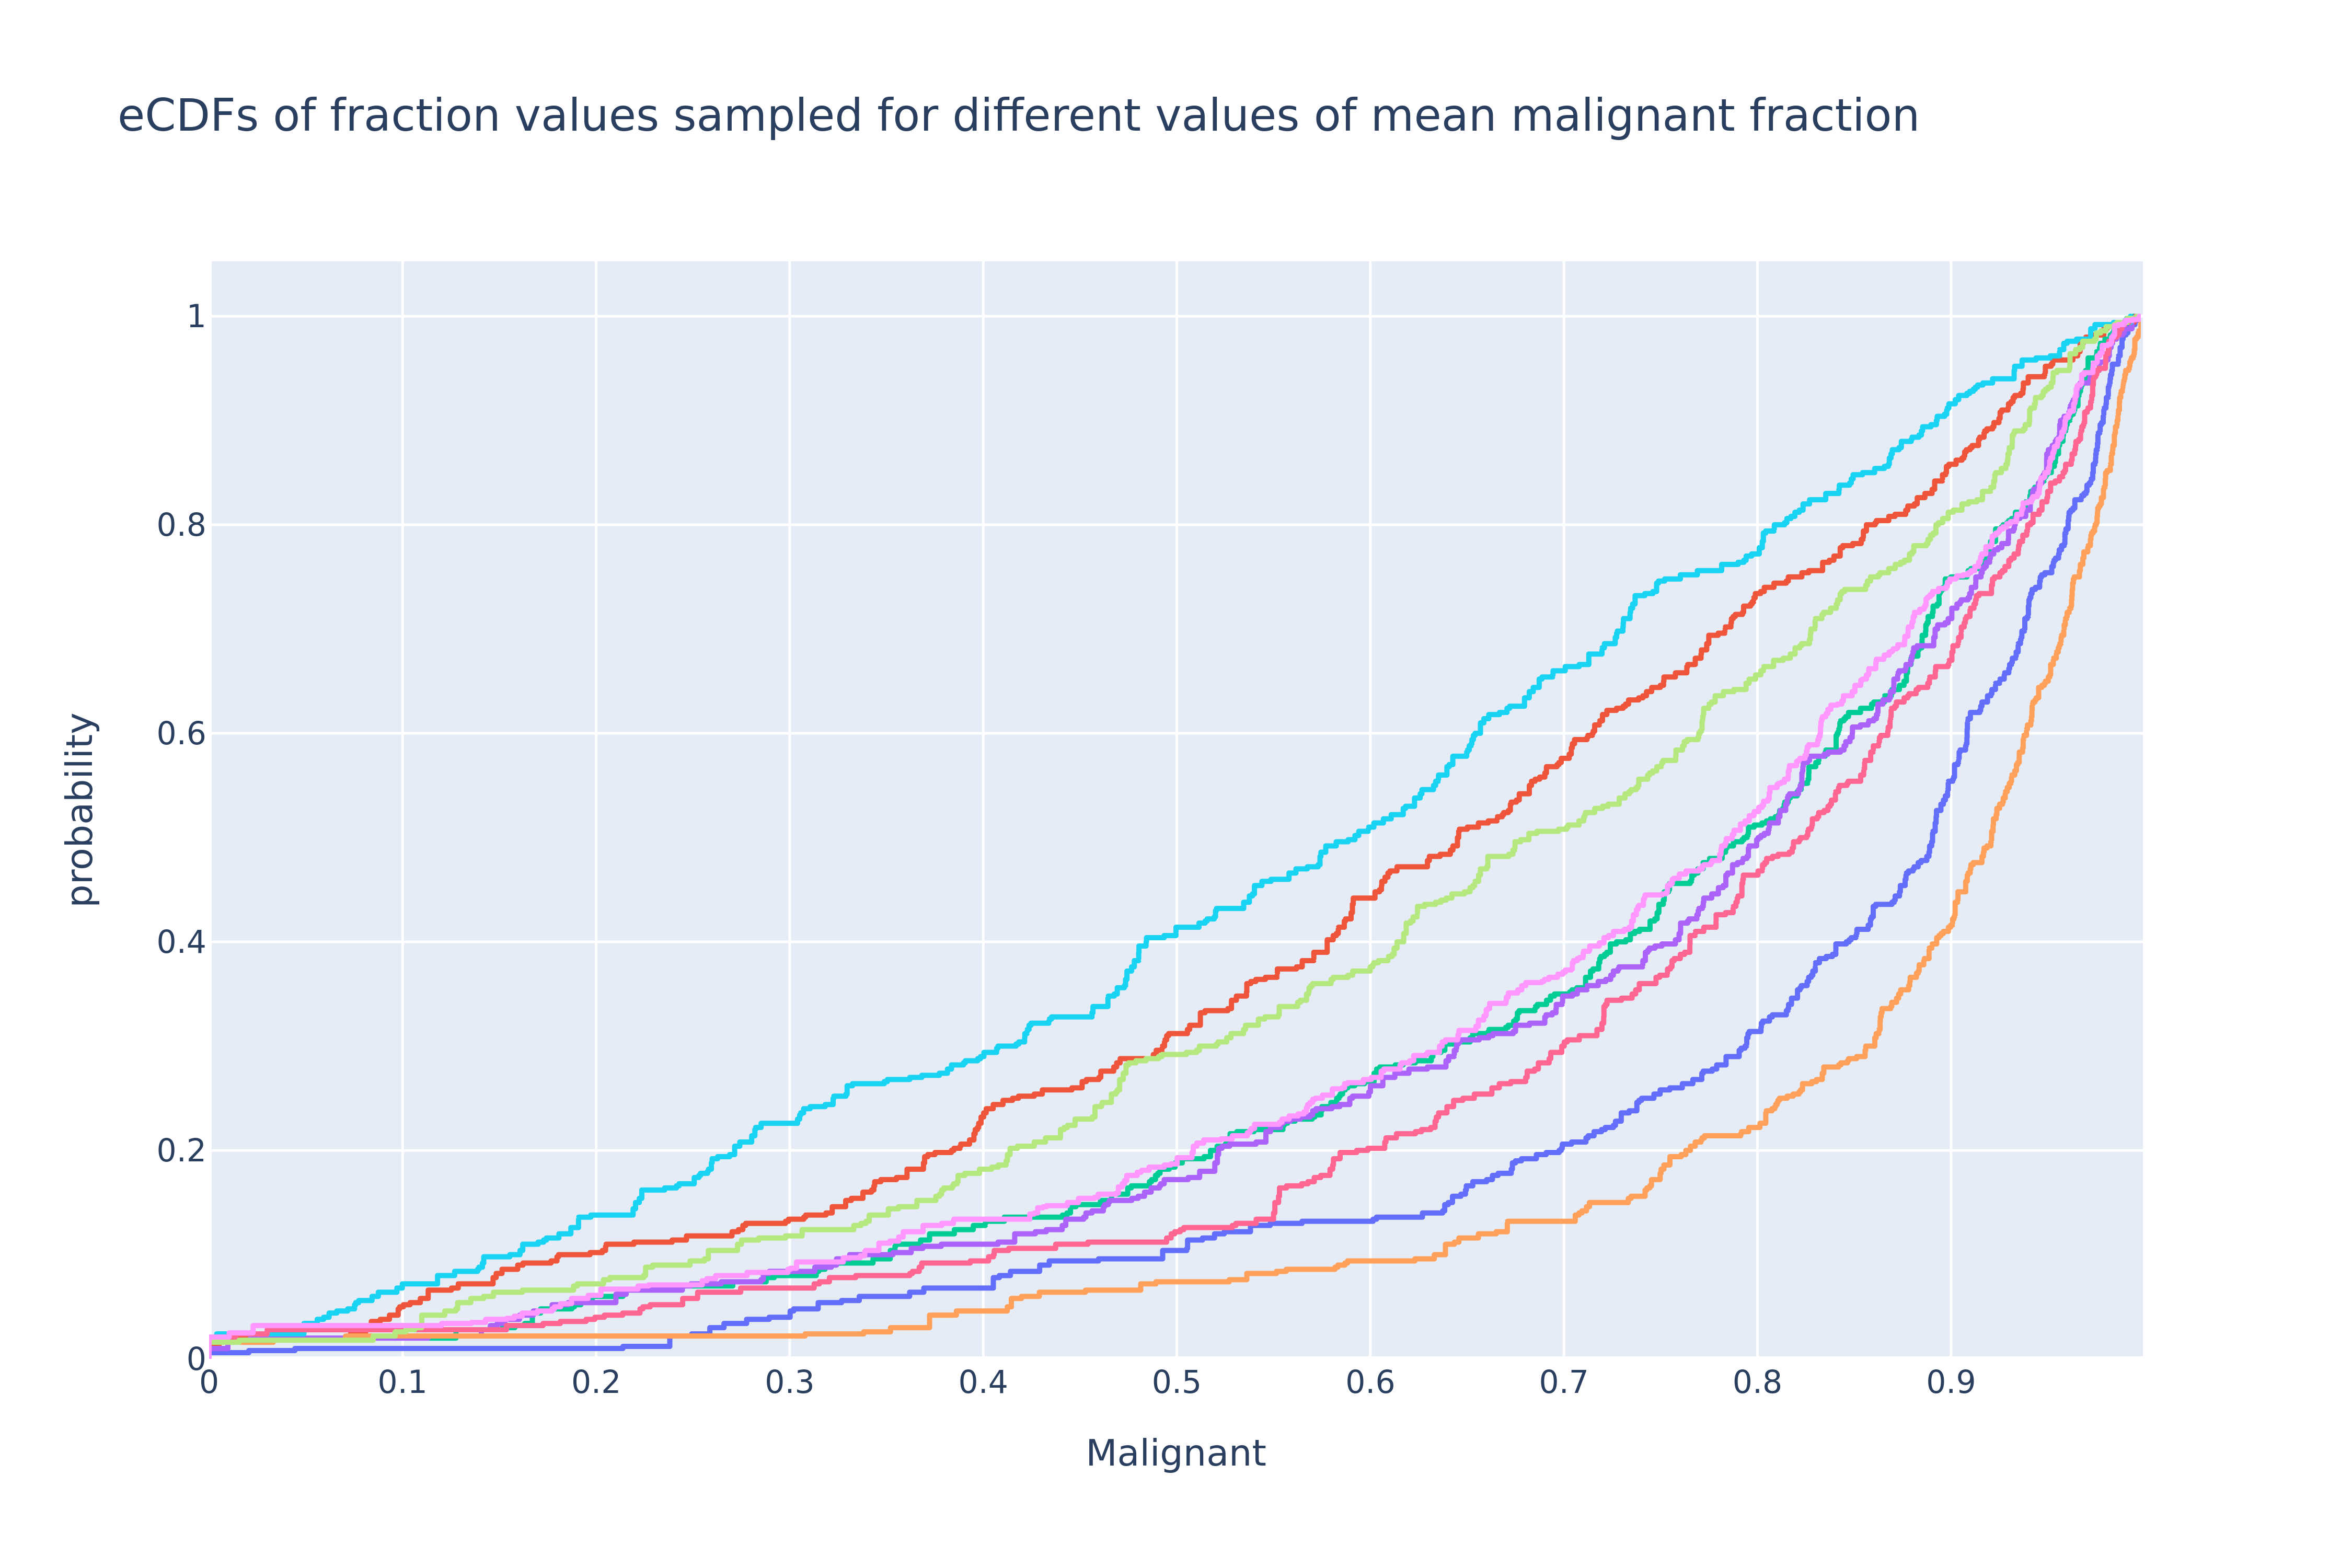

In [7]:
df = df_fractions.reset_index()
# df["color"] = df.apply(lambda row: "{} - {}".format(row["malignant_means"], row["group_id"]), axis=1)
fig = px.ecdf(
    df,
    x="Malignant",
    color="malignant_mean_value",
    title="eCDFs of fraction values sampled for different values of mean malignant fraction",
)
fig.update_layout(
    showlegend=False,
    width=900,
    height=600,
)

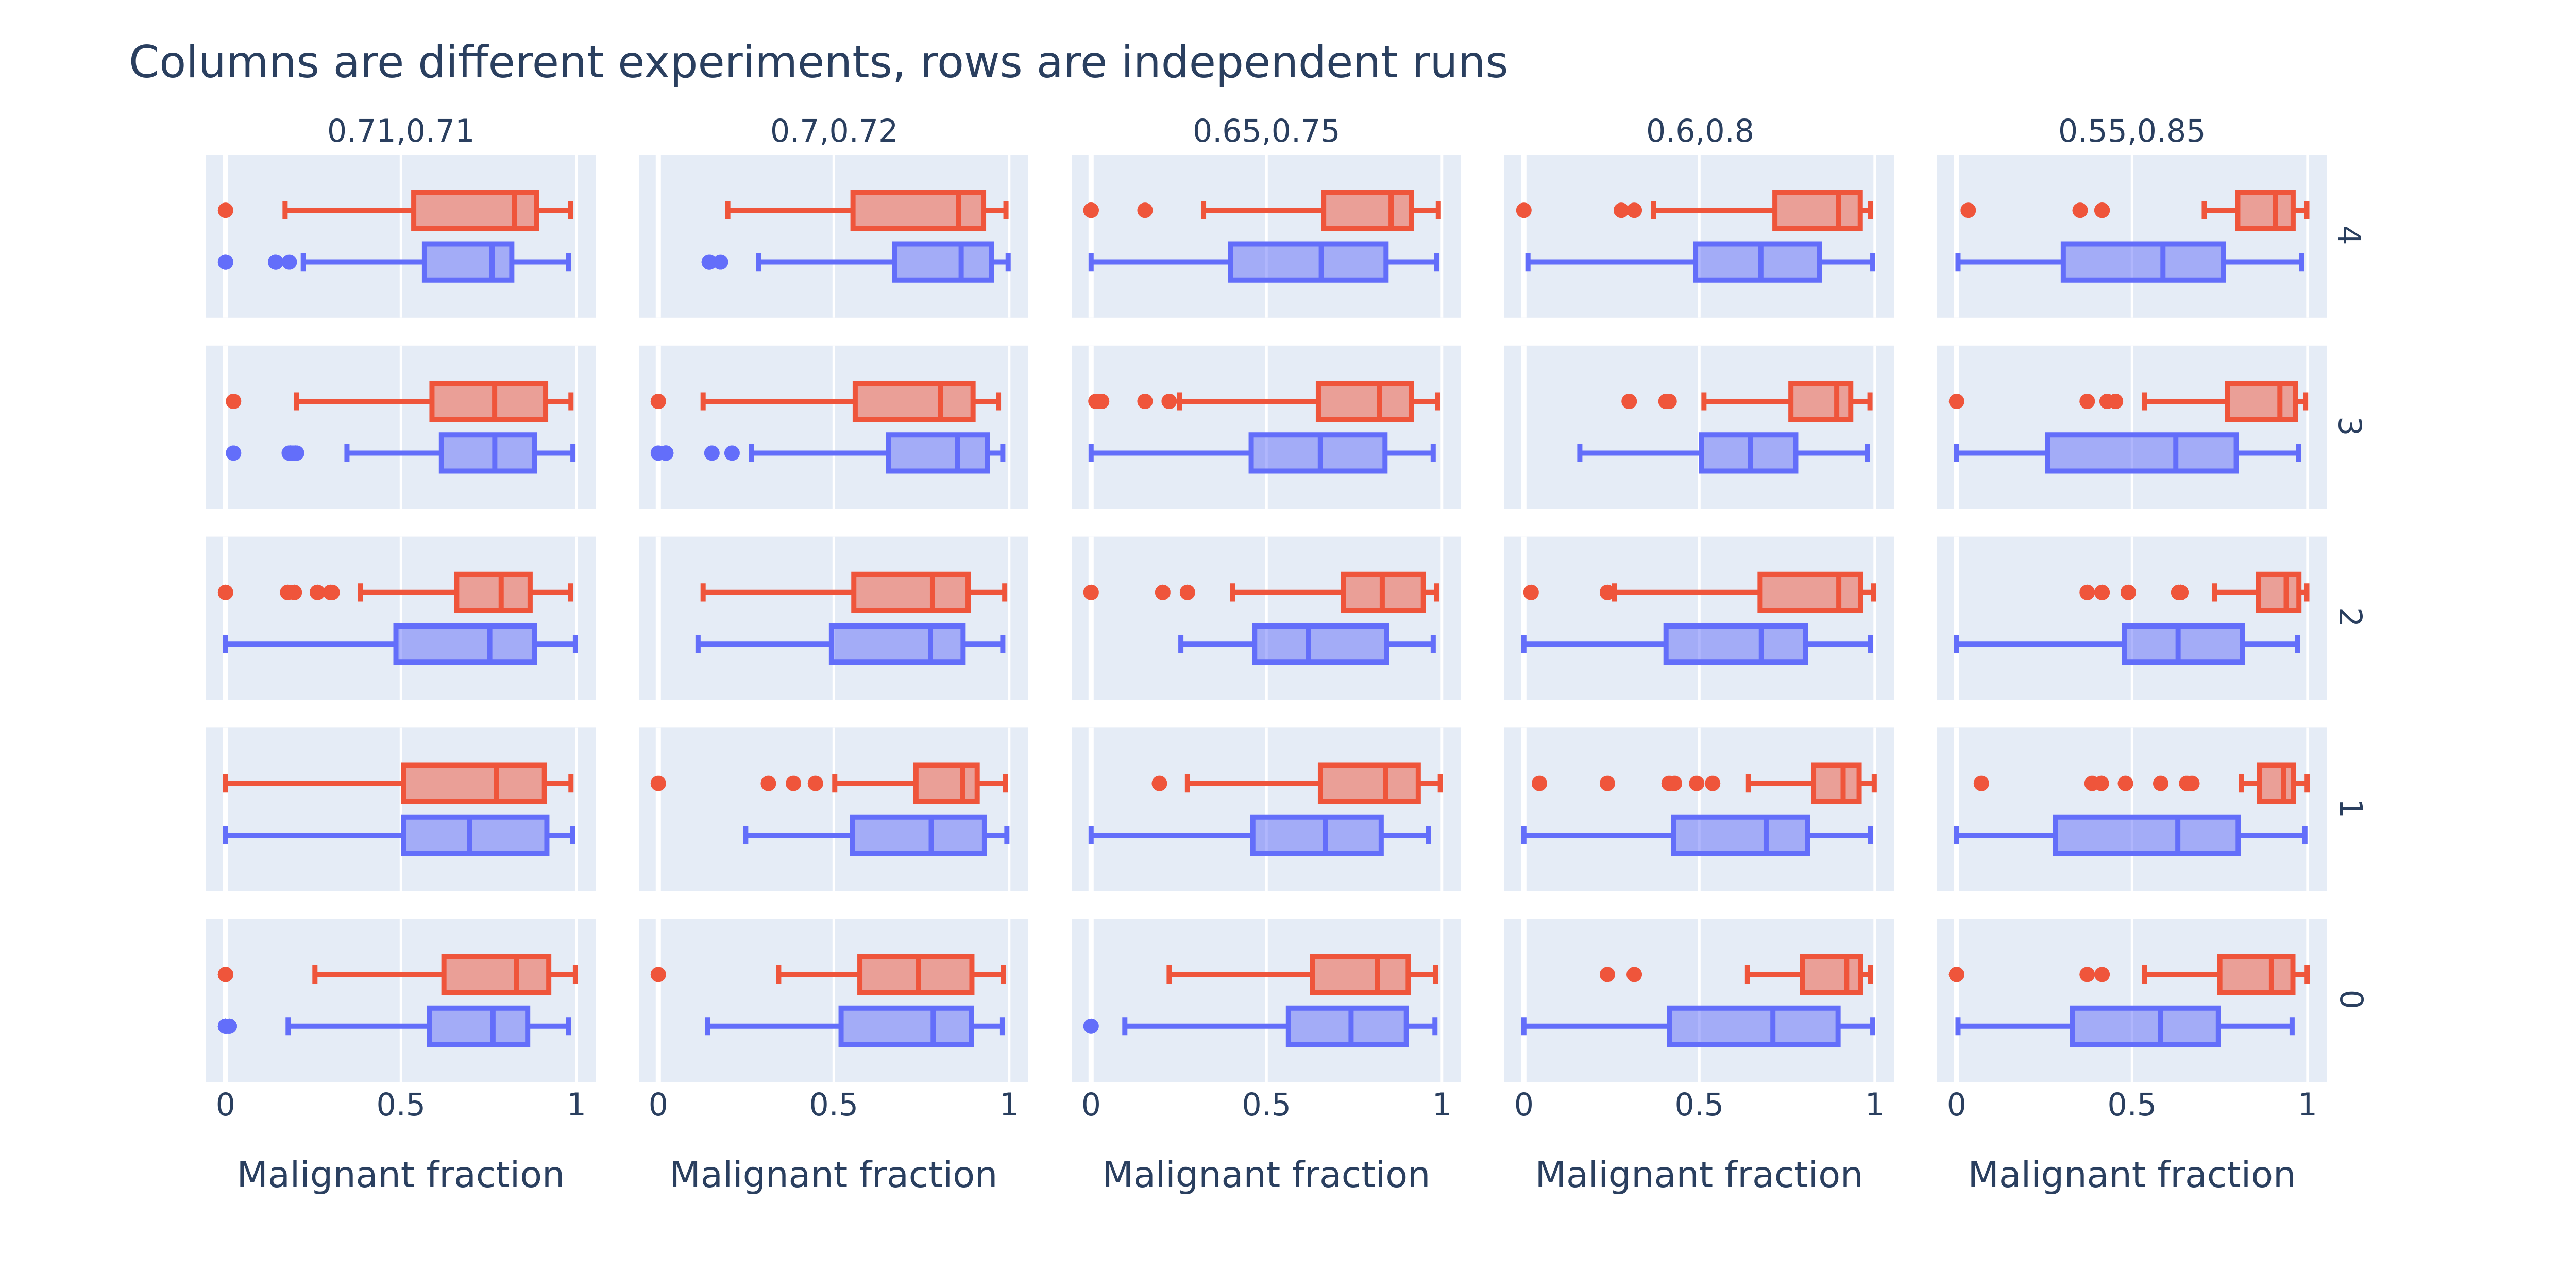

In [8]:
df = df_fractions.reset_index()
df = df.astype({"run_id": int})
df = df.query("run_id < 5")
df.sort_values(["malignant_means"], ascending=False, inplace=True)
fig = px.box(
    df,
    x="Malignant",
    facet_col="malignant_means",
    facet_row="run_id",
    color="group_id",
    labels={"Malignant": "Malignant fraction"},
)
fig.for_each_annotation(
    lambda a: a.update(text=a.text.split("=")[-1])
)  # https://github.com/plotly/plotly_express/issues/36#issuecomment-589718357
fig.update_layout(
    showlegend=False,
    width=1000,
    height=500,
    title="Columns are different experiments, rows are independent runs",
)

### what are fraction means for each group and experiment?

In [9]:
fig = px.box(
    df,
    x="mean",
    facet_col="perturbation",
    facet_row="simulation",
    color="treatment",
    labels={"Malignant": "Malignant fraction"},
)
fig.update_layout(
    width=1500,
    height=600,
    title="Columns are different perturbations, rows are independent runs",
)

ValueError: Value of 'x' is not the name of a column in 'data_frame'. Expected one of ['malignant_means', 'group_id', 'malignant_mean_value', 'sample_id', 'run_id', 'B', 'CAF', 'Endothelial', 'Macrophage', 'Malignant', 'NK', 'T', 'T CD4', 'T CD8'] but received: mean

## volcano plots from run_id=00

- for bulk RNA-seq
- for inferred malignant-specific RNA-seq

In [10]:
importlib.reload(helpers.running_cibersortx.reading_output_files)

from helpers.running_cibersortx.reading_output_files import read_hires_cell_type_gep

In [47]:
experiment_paths = list(path_root.glob("run_id=00/*"))

key_names = ["experiment_name", "data_origin"]

experiments_data = dict()

for path in reversed(sorted(experiment_paths)):
    experiments_data[(path.name, "bulk RNA-seq")] = pd.read_parquet(path / "deg_analysis/gene_stats_bulk.parquet")
    experiments_data[(path.name, "malignant cells (cibersortx)")] = pd.read_parquet(
        path / "deg_analysis/gene_stats_malignant_cibersortx.parquet"
    )

all_dge_results = pd.concat(experiments_data, names=key_names).reset_index(key_names).reset_index(drop=True)

all_dge_results

experiment_name                   data_origin gene_symbol  \
0       malignant_means=0.71,0.71                  bulk RNA-seq        A1BG   
1       malignant_means=0.71,0.71                  bulk RNA-seq         A2M   
2       malignant_means=0.71,0.71                  bulk RNA-seq       A2ML1   
3       malignant_means=0.71,0.71                  bulk RNA-seq      A4GALT   
4       malignant_means=0.71,0.71                  bulk RNA-seq       A4GNT   
...                           ...                           ...         ...   
160625  malignant_means=0.55,0.85  malignant cells (cibersortx)      ZYG11A   
160626  malignant_means=0.55,0.85  malignant cells (cibersortx)      ZYG11B   
160627  malignant_means=0.55,0.85  malignant cells (cibersortx)         ZYX   
160628  malignant_means=0.55,0.85  malignant cells (cibersortx)       ZZEF1   
160629  malignant_means=0.55,0.85  malignant cells (cibersortx)        ZZZ3   

            pval  fold_change  sparsity_overall  -log10_pval  \
0       0.812008     1.016160              0.01     0.090440   
1       0.753773     1.017407              0.00     0.122760   
2       0.676623     1.049026              0.00     0.169653   
3       0.165839     0.662052              0.04     0.780314   
4       0.746216     1.717973              0.89     0.127135   
...          ...          ...               ...          ...   
160625  0.015096     0.799713              0.00     1.821143   
160626  0.001181     0.765514              0.00     2.927922   
160627  0.001431     0.698483              0.00     2.844462   
160628  0.009068     0.710809              0.00     2.042473   
160629  0.200939     0.873304              0.00     0.696935   

        log2_fold_change  -log10_pval_signed  significant_bh_fdr=0.10  \
0               0.023128            0.090440                    False   
1               0.024897            0.122760                    False   
2               0.069050            0.169653                    False   
3              -0.594984           -0.780314                    False   
4               0.780707            0.127135                    False   
...                  ...                 ...                      ...   
160625         -0.322446           -1.821143                    False   
160626         -0.385500           -2.927922                     True   
160627         -0.517702           -2.844462                     True   
160628         -0.492466           -2.042473                     True   
160629         -0.195443           -0.696935                    False   

        significant_bh_fdr=0.25  perturbed  
0                         False      False  
1                         False      False  
2                         False      False  
3                         False      False  
4                         False      False  
...                         ...        ...  
160625                     True      False  
160626                     True      False  
160627                     True      False  
160628                     True      False  
160629                    False      False  

[160630 rows x 12 columns]

2023-01-27 14:58:32,101 6789/MainThread helpers.deg_analysis DEBUG
adding data for k=0, row_number=1, column_number=1
2023-01-27 14:58:32,112 6789/MainThread helpers.deg_analysis DEBUG
-log10(pval_threshold) for alpha=0.1, key=('malignant_means=0.71,0.71', 'Bulk simulated'):, 5.506856655023323
2023-01-27 14:58:32,131 6789/MainThread helpers.deg_analysis DEBUG
-log10(pval_threshold) for alpha=0.25, key=('malignant_means=0.71,0.71', 'Bulk simulated'):, 5.108916646351285
2023-01-27 14:58:32,141 6789/MainThread helpers.deg_analysis DEBUG
adding data for k=0, row_number=2, column_number=1
2023-01-27 14:58:32,151 6789/MainThread helpers.deg_analysis DEBUG
-log10(pval_threshold) for alpha=0.1, key=('malignant_means=0.71,0.71', 'Malignant inferred'):, 5.506856655023323
2023-01-27 14:58:32,172 6789/MainThread helpers.deg_analysis DEBUG
-log10(pval_threshold) for alpha=0.25, key=('malignant_means=0.71,0.71', 'Malignant inferred'):, 5.108916646351285
2023-01-27 14:58:32,186 6789/MainThread helper

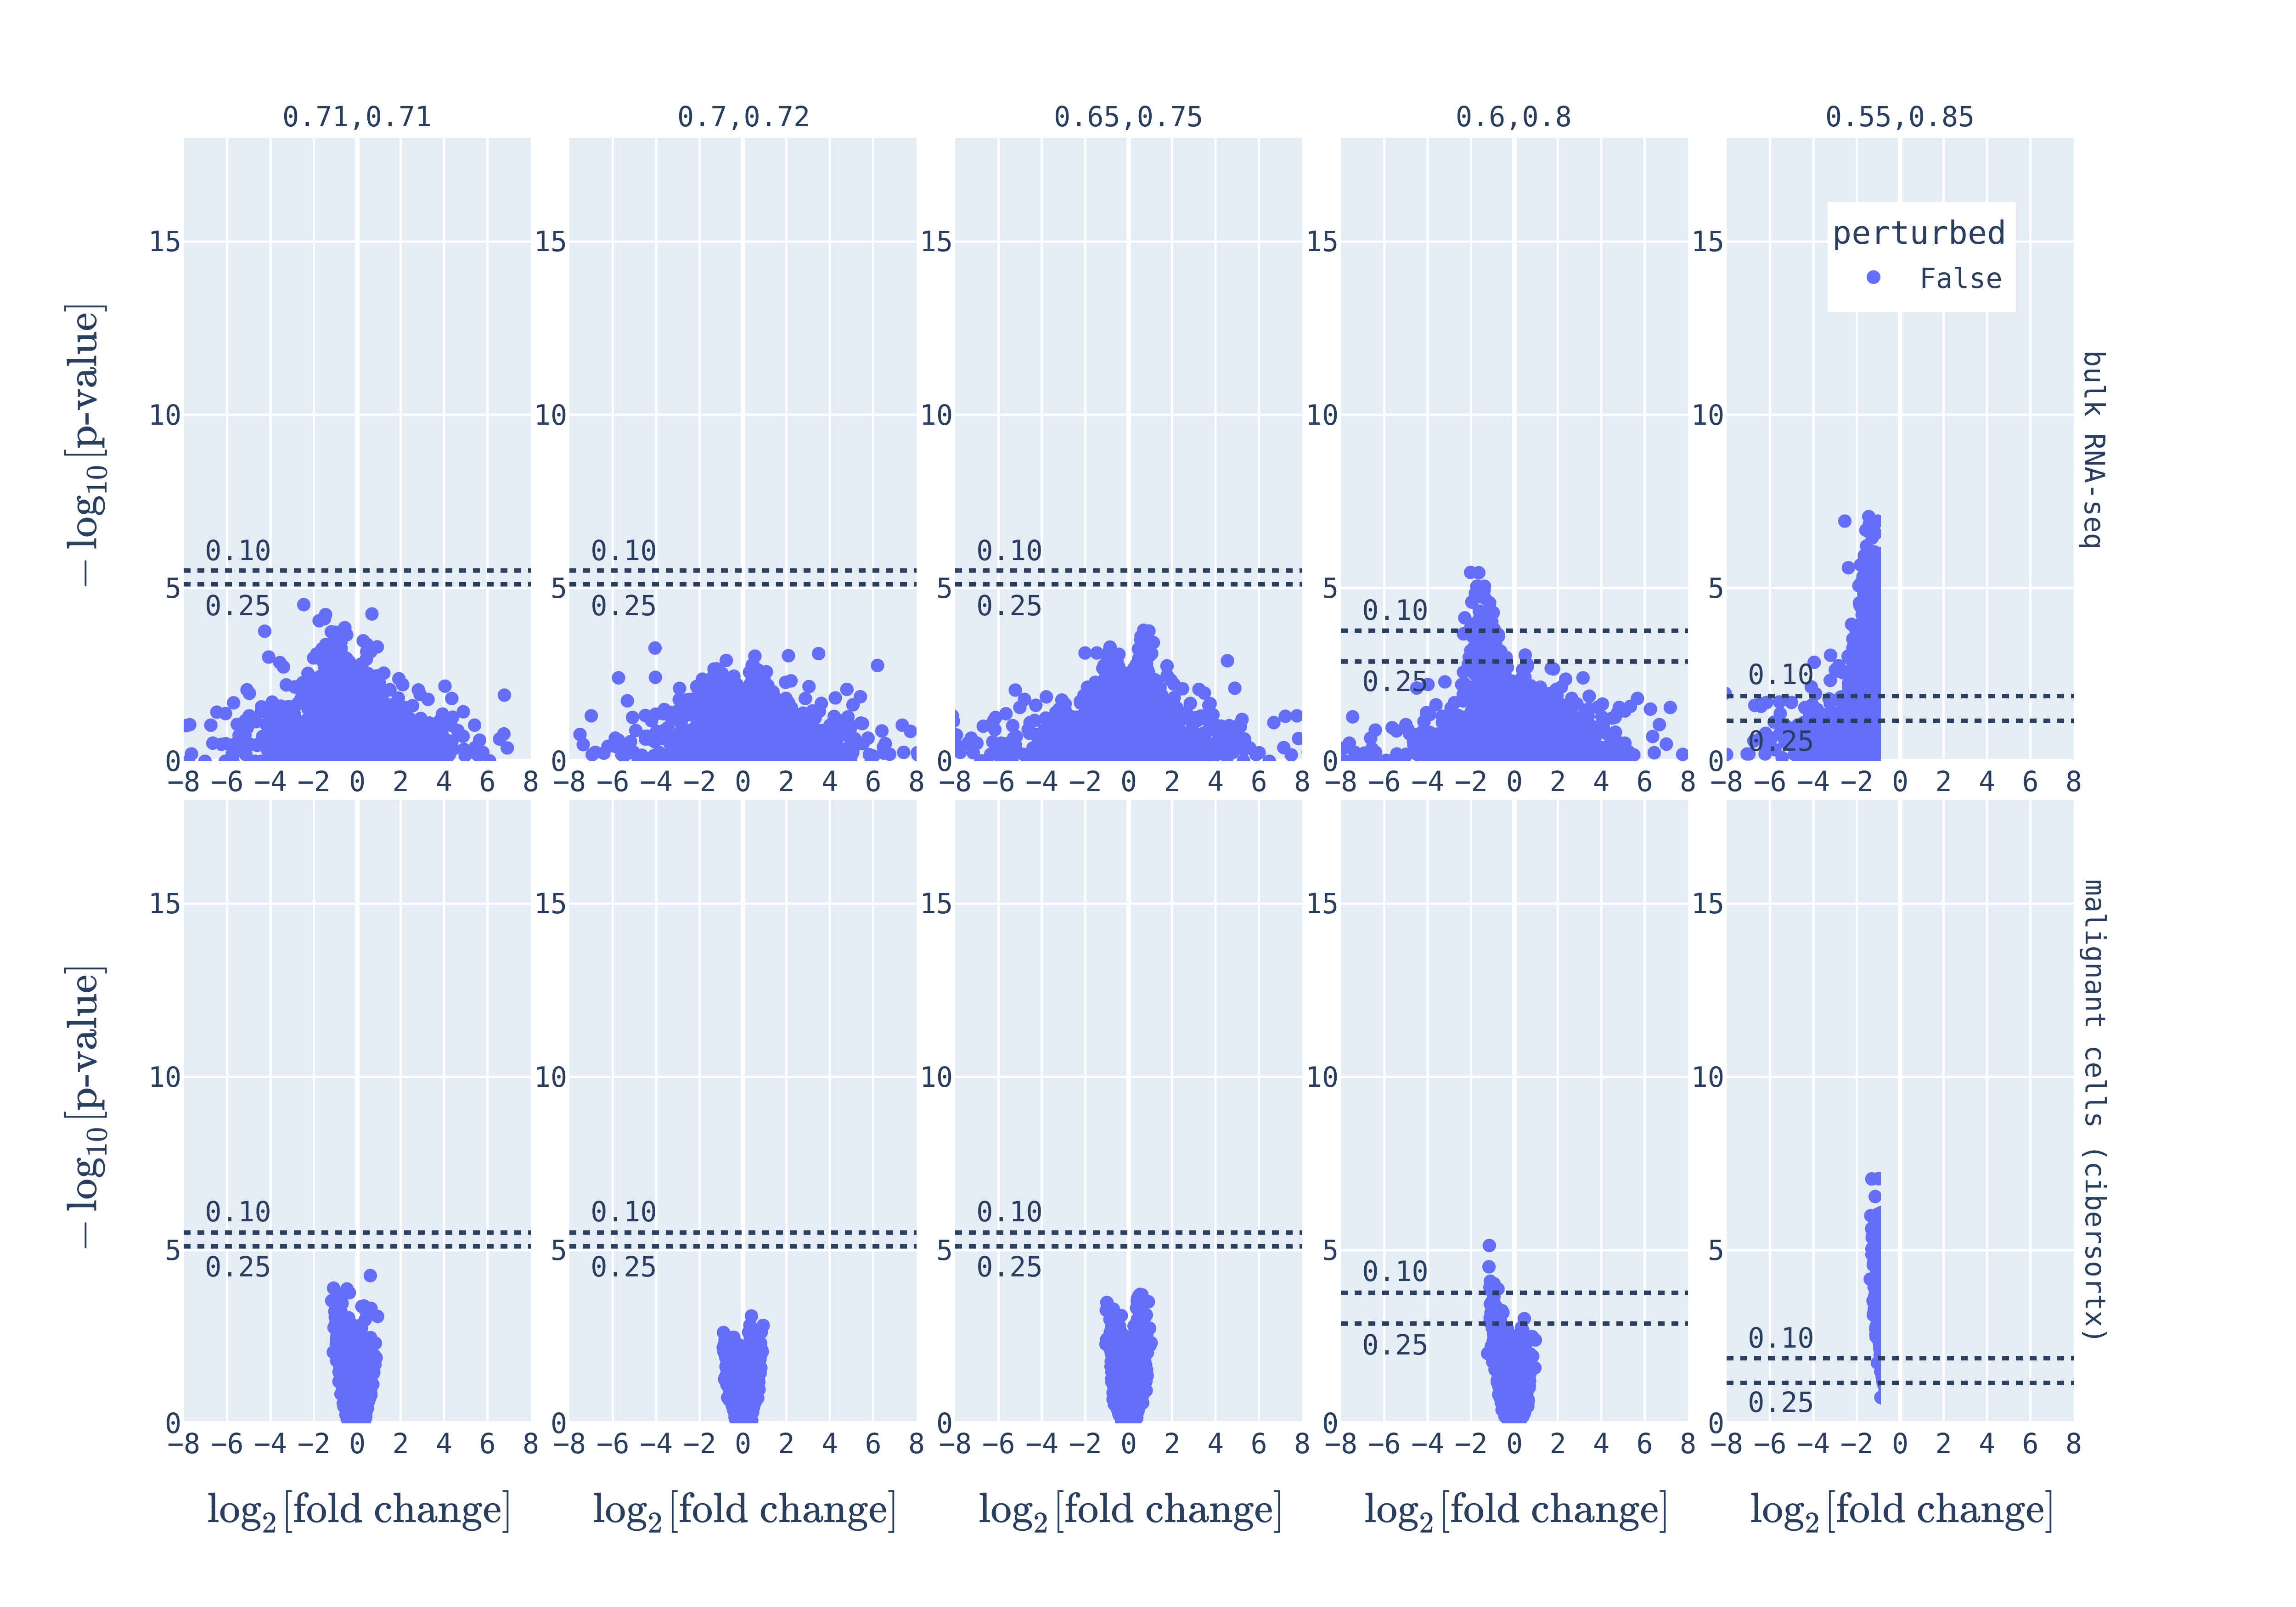

In [48]:
importlib.reload(helpers.deg_analysis)

from helpers.deg_analysis import add_fdr_lines, make_volcano_facets

fig = make_volcano_facets(all_dge_results, horizontal=True)
fig = add_fdr_lines(fig, all_dge_results, horizontal=True)
# fig.update_layout(title=title, height=1200)
fig.update_layout(height=700, width=1000)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.write_image("plot.png", scale=2)
fig

## plot of falsely called differentially expressed genes

In [50]:
experiment_paths = list(reversed(sorted(path_root.glob("**/deg_analysis/*"))))


def read_parquet(path):
    df = pd.read_parquet(path)
    for thing in str(path).split("/"):
        if "=" in thing:
            col, value = thing.split("=", 1)
            df[col] = value
    df["gep_name"] = path.name[11:][:-8]
    return df


all_dge_results = dd.from_map(read_parquet, experiment_paths).compute()

In [51]:
all_dge_results.sample(10)

gene_symbol      pval  fold_change  sparsity_overall  -log10_pval  \
2694      CHORDC1  0.931329     0.982473              0.00     0.030897   
2953         COCH  0.031902     0.613374              0.00     1.496181   
4369         ERI3  0.514746     1.083903              0.00     0.288407   
3056        COTL1  0.980750     1.015861              0.00     0.008442   
5163        FUT11  0.120047     1.530144              0.03     0.920648   
14624        TTPA  0.014443     0.675667              0.00     1.840341   
3206       CSF2RB  0.553268     1.037016              0.02     0.257064   
4490         FADD  0.588394     1.072174              0.00     0.230332   
10696       PRDM4  0.649105     1.174807              0.04     0.187685   
6760        ITIH1  0.327086     0.997637              0.00     0.485338   

       log2_fold_change  -log10_pval_signed  significant_bh_fdr=0.10  \
2694          -0.025510           -0.030897                    False   
2953          -0.705161           -1.496181                    False   
4369           0.116236            0.288407                    False   
3056           0.022703            0.008442                    False   
5163           0.613667            0.920648                    False   
14624         -0.565615           -1.840341                     True   
3206           0.052439            0.257064                    False   
4490           0.100539            0.230332                    False   
10696          0.232423            0.187685                    False   
6760          -0.003412           -0.485338                    False   

       significant_bh_fdr=0.25  perturbed run_id malignant_means  \
2694                     False      False     05       0.55,0.85   
2953                     False      False     02       0.65,0.75   
4369                     False      False     03       0.65,0.75   
3056                     False      False     00       0.65,0.75   
5163                     False      False     02       0.71,0.71   
14624                     True      False     06         0.6,0.8   
3206                     False      False     00        0.7,0.72   
4490                     False      False     02       0.55,0.85   
10696                    False      False     03       0.65,0.75   
6760                     False      False     01         0.6,0.8   

                   gep_name  
2694   malignant_cibersortx  
2953   malignant_cibersortx  
4369                   bulk  
3056   malignant_cibersortx  
5163                   bulk  
14624  malignant_cibersortx  
3206                   bulk  
4490   malignant_cibersortx  
10696                  bulk  
6760   malignant_cibersortx

gep_name           bulk  malignant_cibersortx
malignant_means                              
0.71,0.71           0.0                   0.0
0.7,0.72            0.3                   0.3
0.65,0.75          54.0                  14.9
0.6,0.8           814.9                 544.1
0.55,0.85        3069.8                2360.5


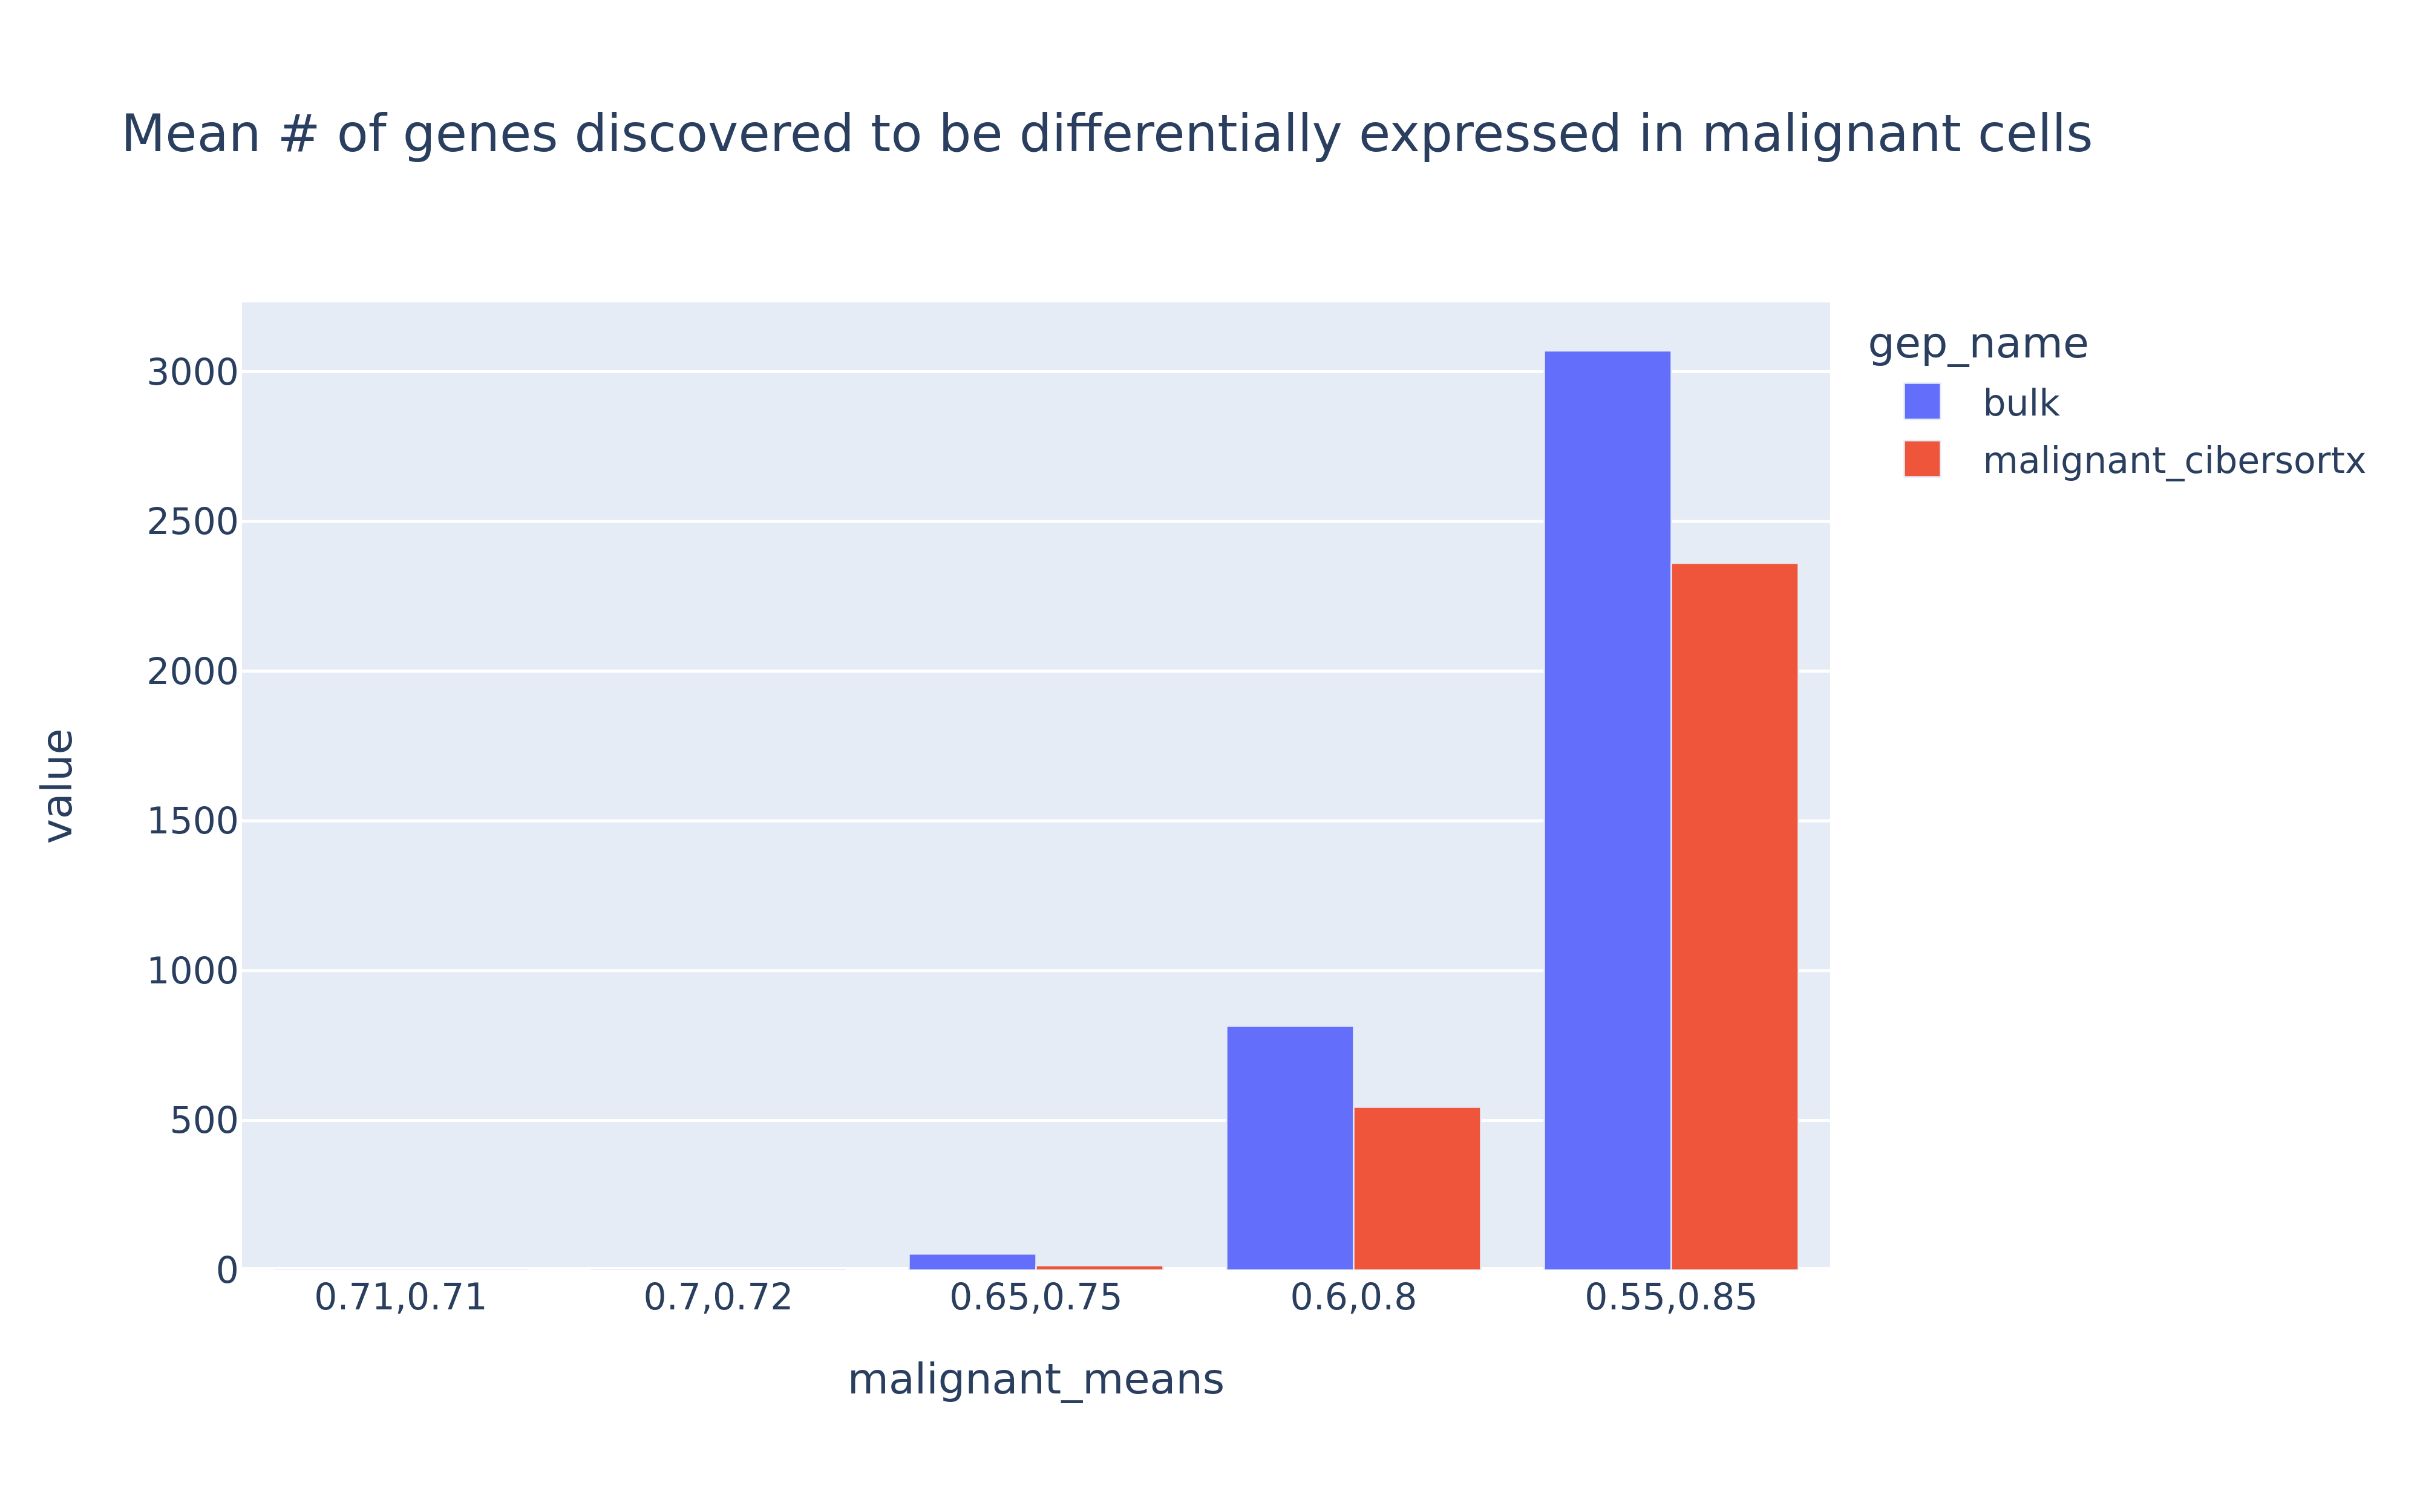

In [52]:
# df.groupby("malignant_means")
df = (
    all_dge_results.groupby(["malignant_means", "gep_name", "run_id"])["significant_bh_fdr=0.10"]
    .sum()
    .unstack("gep_name")
    .groupby("malignant_means")
    .mean()
    .sort_index(ascending=False)
)

# px.
# px.bar(df)
print(df)
fig = px.bar(df, barmode="group", title="Mean # of genes discovered to be differentially expressed in malignant cells")
fig.update_layout(height=500, width=800)

In [53]:
all_dge_results.groupby(["malignant_means", "gep_name", "run_id"])["significant_bh_fdr=0.10"].agg(func=["sum", "count"])

sum  count
malignant_means gep_name             run_id             
0.55,0.85       bulk                 00      2630  16063
                                     01      3621  16063
                                     02      3458  16063
                                     03      2627  16063
                                     04      1906  16063
...                                           ...    ...
0.71,0.71       malignant_cibersortx 05         0  16063
                                     06         0  16063
                                     07         0  16063
                                     08         0  16063
                                     09         0  16063

[100 rows x 2 columns]

In [19]:
# df.groupby("malignant_means")
counts = (
    all_dge_results.groupby(["malignant_means", "gep_name", "run_id"])["significant_bh_fdr=0.10"]
    .agg(func=["sum", "count"])
    .reset_index()
    .sort_values(by="malignant_means", ascending=False)
)
df = counts.query("gep_name == 'malignant_cibersortx'")
df["empirical_fdr"] = df["sum"] / df["count"]
df

/tmp/ipykernel_6789/96791502.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



malignant_means              gep_name run_id   sum  count  empirical_fdr
99       0.71,0.71  malignant_cibersortx     09     0  16063       0.000000
90       0.71,0.71  malignant_cibersortx     00     0  16063       0.000000
95       0.71,0.71  malignant_cibersortx     05     0  16063       0.000000
91       0.71,0.71  malignant_cibersortx     01     0  16063       0.000000
97       0.71,0.71  malignant_cibersortx     07     0  16063       0.000000
96       0.71,0.71  malignant_cibersortx     06     0  16063       0.000000
98       0.71,0.71  malignant_cibersortx     08     0  16063       0.000000
94       0.71,0.71  malignant_cibersortx     04     0  16063       0.000000
93       0.71,0.71  malignant_cibersortx     03     0  16063       0.000000
92       0.71,0.71  malignant_cibersortx     02     0  16063       0.000000
76        0.7,0.72  malignant_cibersortx     06     0  16063       0.000000
70        0.7,0.72  malignant_cibersortx     00     0  16063       0.000000
75        0.7,0.72  malignant_cibersortx     05     0  16063       0.000000
71        0.7,0.72  malignant_cibersortx     01     0  16063       0.000000
78        0.7,0.72  malignant_cibersortx     08     0  16063       0.000000
77        0.7,0.72  malignant_cibersortx     07     0  16063       0.000000
79        0.7,0.72  malignant_cibersortx     09     1  16063       0.000062
74        0.7,0.72  malignant_cibersortx     04     2  16063       0.000125
73        0.7,0.72  malignant_cibersortx     03     0  16063       0.000000
72        0.7,0.72  malignant_cibersortx     02     0  16063       0.000000
51       0.65,0.75  malignant_cibersortx     01     0  16063       0.000000
59       0.65,0.75  malignant_cibersortx     09     1  16063       0.000062
58       0.65,0.75  malignant_cibersortx     08     0  16063       0.000000
57       0.65,0.75  malignant_cibersortx     07     0  16063       0.000000
56       0.65,0.75  malignant_cibersortx     06     0  16063       0.000000
55       0.65,0.75  malignant_cibersortx     05     0  16063       0.000000
54       0.65,0.75  malignant_cibersortx     04     0  16063       0.000000
53       0.65,0.75  malignant_cibersortx     03     0  16063       0.000000
52       0.65,0.75  malignant_cibersortx     02   148  16063       0.009214
50       0.65,0.75  malignant_cibersortx     00     0  16063       0.000000
31         0.6,0.8  malignant_cibersortx     01  1913  16063       0.119094
30         0.6,0.8  malignant_cibersortx     00     0  16063       0.000000
35         0.6,0.8  malignant_cibersortx     05     4  16063       0.000249
38         0.6,0.8  malignant_cibersortx     08   367  16063       0.022848
37         0.6,0.8  malignant_cibersortx     07   132  16063       0.008218
36         0.6,0.8  malignant_cibersortx     06  2650  16063       0.164975
39         0.6,0.8  malignant_cibersortx     09    13  16063       0.000809
34         0.6,0.8  malignant_cibersortx     04    48  16063       0.002988
33         0.6,0.8  malignant_cibersortx     03   314  16063       0.019548
32         0.6,0.8  malignant_cibersortx     02     0  16063       0.000000
10       0.55,0.85  malignant_cibersortx     00  1593  16063       0.099172
11       0.55,0.85  malignant_cibersortx     01  2915  16063       0.181473
12       0.55,0.85  malignant_cibersortx     02  2730  16063       0.169956
13       0.55,0.85  malignant_cibersortx     03  1911  16063       0.118969
14       0.55,0.85  malignant_cibersortx     04  1268  16063       0.078939
15       0.55,0.85  malignant_cibersortx     05  2783  16063       0.173255
16       0.55,0.85  malignant_cibersortx     06  5387  16063       0.335367
17       0.55,0.85  malignant_cibersortx     07  2354  16063       0.146548
18       0.55,0.85  malignant_cibersortx     08  1555  16063       0.096806
19       0.55,0.85  malignant_cibersortx     09  1109  16063       0.069041

In [20]:
df.pivot(index="run_id", columns="malignant_means", values="sum").sort_index(axis=1, ascending=False)

malignant_means  0.71,0.71  0.7,0.72  0.65,0.75  0.6,0.8  0.55,0.85
run_id                                                             
00                       0         0          0        0       1593
01                       0         0          0     1913       2915
02                       0         0        148        0       2730
03                       0         0          0      314       1911
04                       0         2          0       48       1268
05                       0         0          0        4       2783
06                       0         0          0     2650       5387
07                       0         0          0      132       2354
08                       0         0          0      367       1555
09                       0         1          1       13       1109

#### nice fig, finally

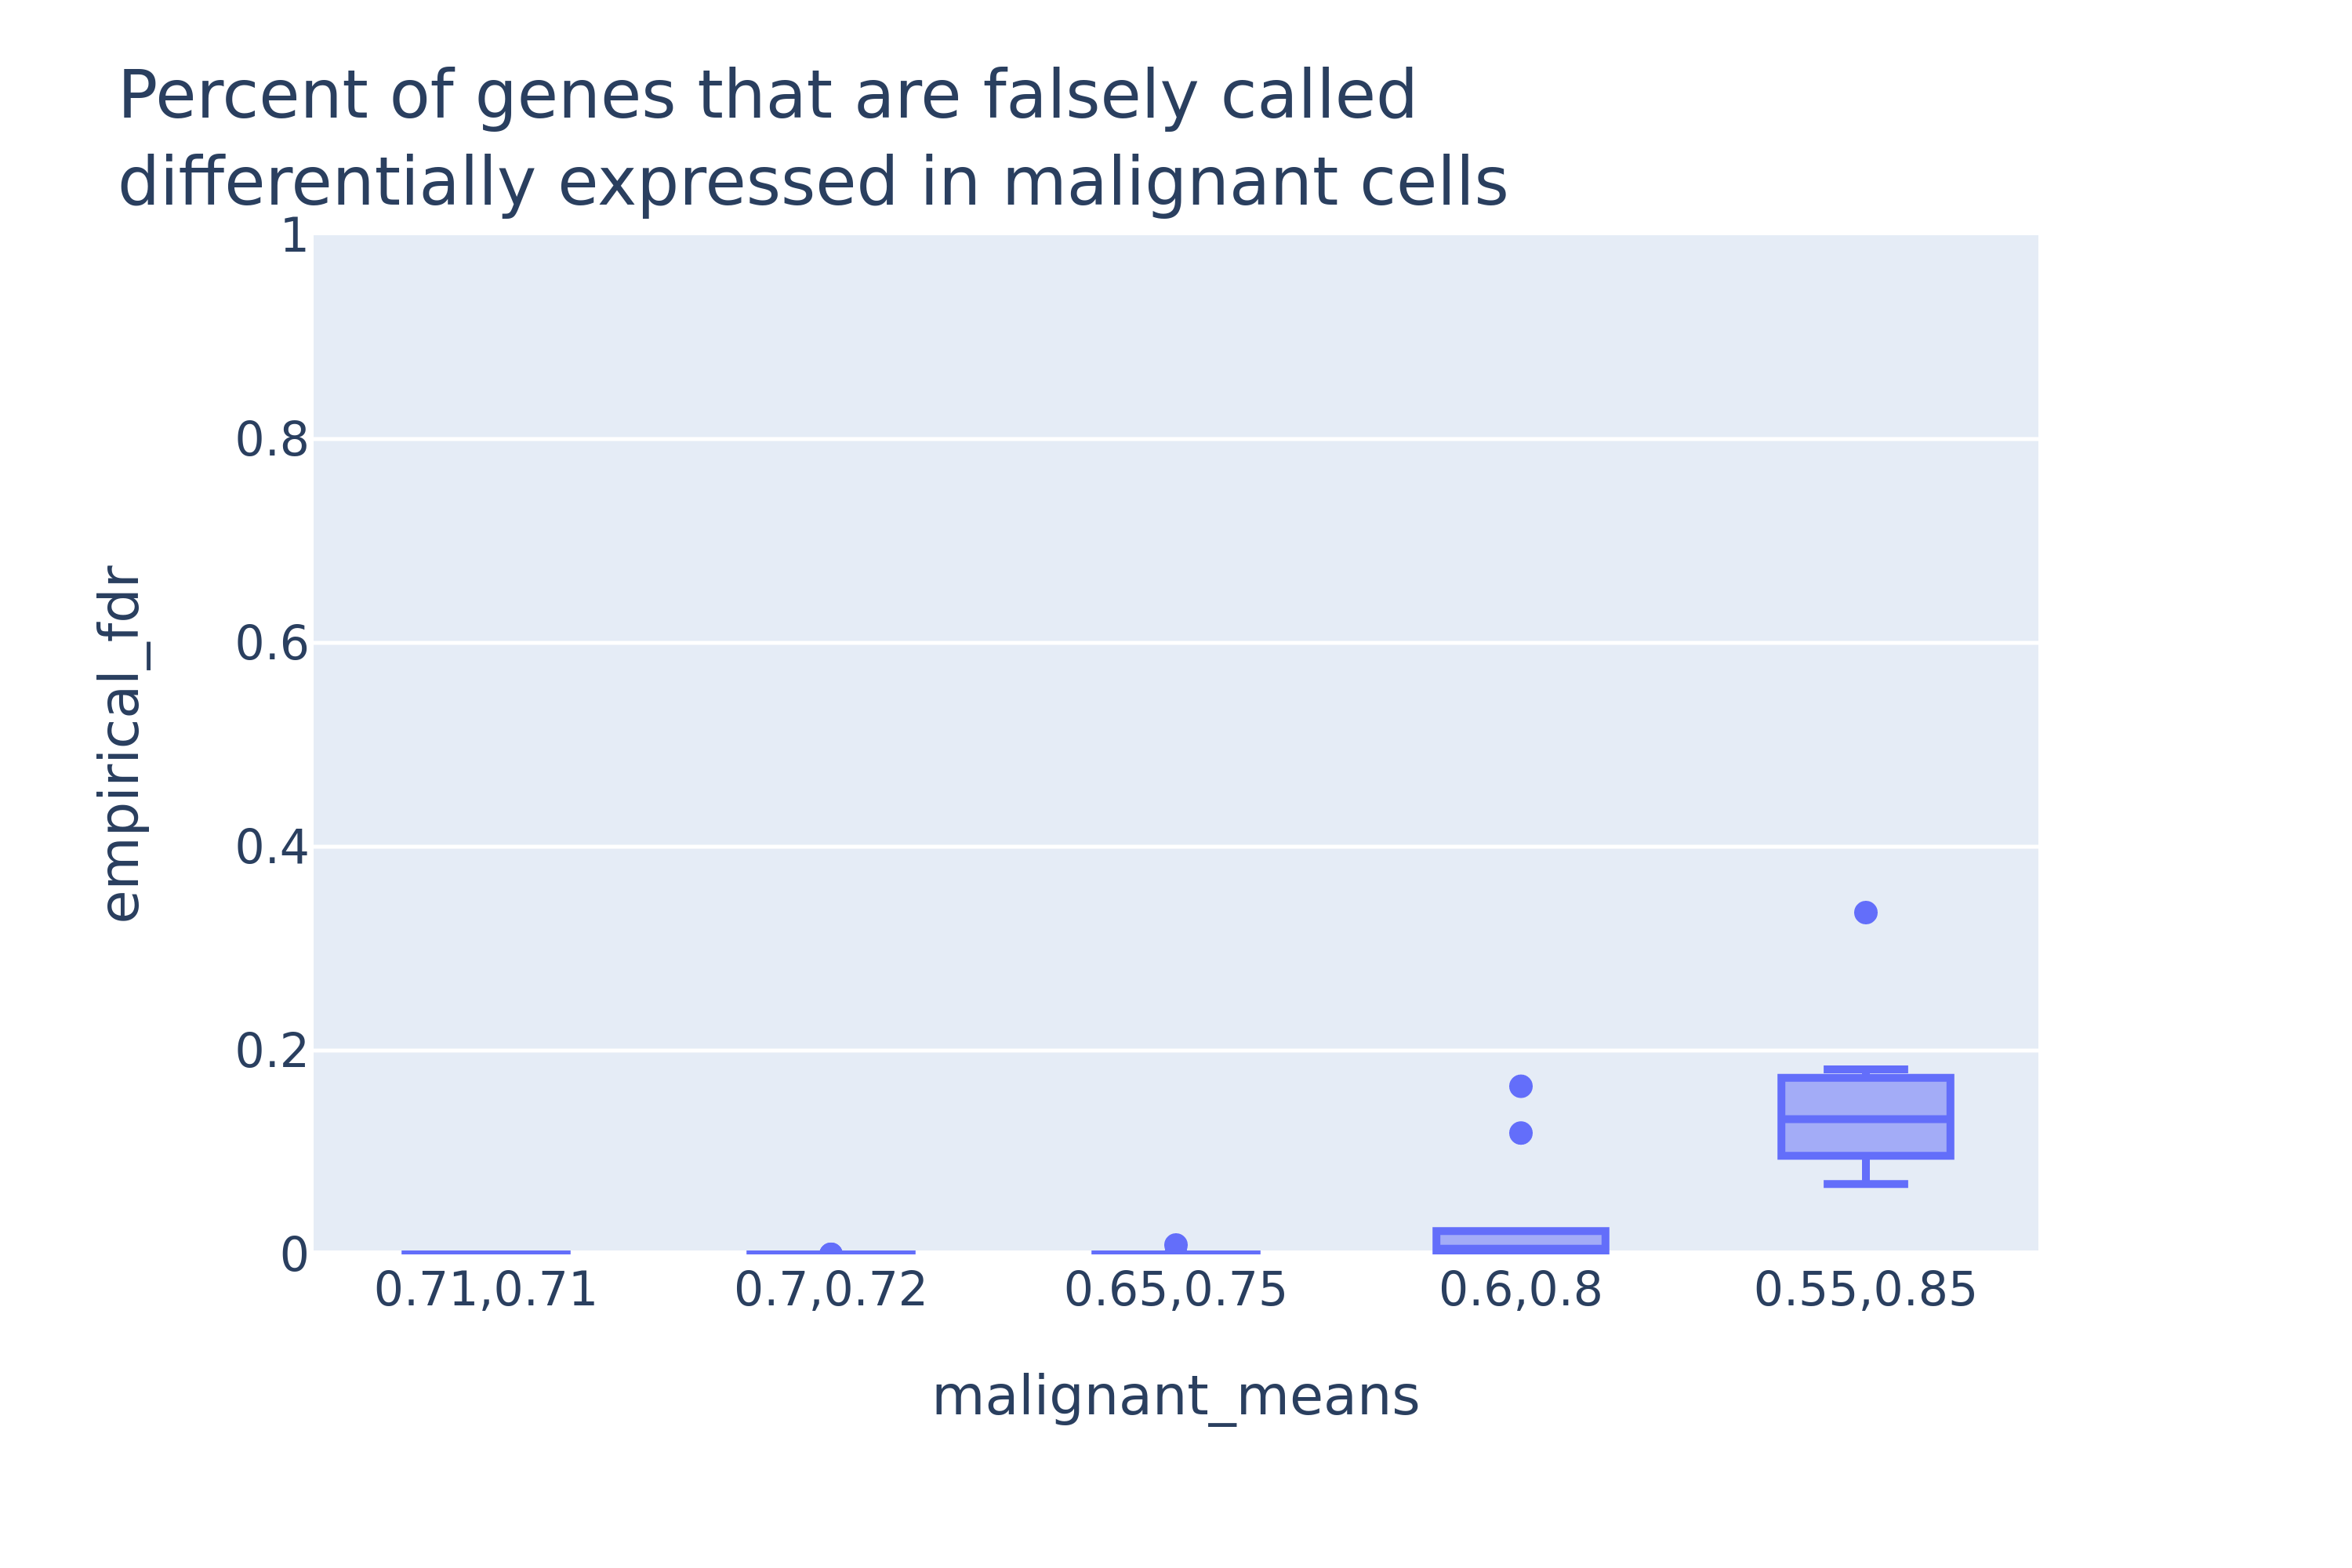

In [21]:
fig = px.box(df, x="malignant_means", y="empirical_fdr")
fig.update_yaxes(range=(0, 1))
fig.update_layout(
    width=600,
    height=400,
    title="Percent of genes that are falsely called <br>differentially expressed in malignant cells",
)
fig